In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import spotipy
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials


# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from scipy.signal import savgol_filter

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix

sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Set seed for random generation
seed = 3569

In [67]:
df_spotify = pd.read_pickle('sources/dataset_integrado.pickle')
df_spotify = df_spotify.drop(
    [
        'disc_number',
        'duration_ms',
        'popularity',
        'track_number',
    ],
    1
)

In [68]:
genre_config = {
    'jazz': 1,
    'classical' : 2,
    'drum-and-bass' : 3,
    'death-metal' : 4,
    'ambient' : 5,
    'ska' : 6,
    'singer-songwriter' : 7,
    'opera' : 8,
    'trance' : 9
}

genre_real = df_spotify['genre']
genre_numeric = [genre_config[item] for item in genre_real]

In [69]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df_spotify.select_dtypes(include=numerics)

In [70]:
from sklearn.preprocessing import quantile_transform

df_numeric_normal = pd.DataFrame(
    quantile_transform(
        df_numeric, 
        output_distribution = 'normal', 
        random_state = 0, 
        copy = True
    ),
    columns=df_numeric.columns,
    index=df_numeric.index
)

df_numeric_uniform = pd.DataFrame(
    quantile_transform(
        df_numeric,
        output_distribution = 'uniform',
        random_state = 0,
        copy = True
    ),
    columns=df_numeric.columns,
    index=df_numeric.index
)

In [71]:
dfeature = pd.read_pickle("sources/importance.pickle")

for k,row in dfeature.iterrows():
    df_numeric[row['feature']] = df_numeric[row['feature']]*100*row['importance']
    df_numeric_uniform[row['feature']] = df_numeric_uniform[row['feature']]*100*row['importance']
    df_numeric_normal[row['feature']] = df_numeric_normal[row['feature']]*100*row['importance']

<ipython-input-71-42866fe5846e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[row['feature']] = df_numeric[row['feature']]*100*row['importance']


In [72]:
def plot_conf_matrix(real, Z2, xlabels, description):
    mat = confusion_matrix(real, Z2)
    sns.heatmap(
        mat.T,
        square=True,
        annot=True,
        fmt='d',
        cbar=False,
        xticklabels=xlabels,
        yticklabels=range(9)
    )
    plt.xlabel('Real')
    plt.ylabel(description)
    plt.show()

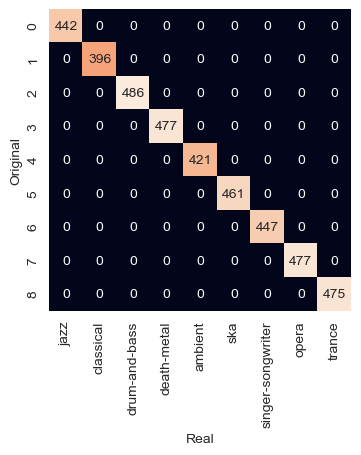

In [73]:
n=9
np.random.seed(seed)

genres = genre_real.unique()

plot_conf_matrix(
    genre_real.values,
    genre_real.values,
    genres,
    'Original'
)

In [74]:
# Clusterizamos nuestros datos con k-means
k = 8
kmeans_test = KMeans(
        n_clusters=k,
        random_state=seed
    )
kmeans_test.fit(df_numeric)
tmp = pd.DataFrame({'Genres': genre_real, 'Clusters': kmeans_test.labels_})
ct0 = pd.crosstab(tmp['Genres'], tmp["Clusters"])
ct0

Clusters,0,1,2,3,4,5,6,7
Genres,,,,,,,,
ambient,9,95,21,114,2,178,23,0
classical,92,194,1,19,0,70,18,2
death-metal,1,3,3,4,381,0,36,58
drum-and-bass,1,0,86,3,12,0,39,336
jazz,13,96,24,131,0,28,119,10
opera,326,103,0,8,0,2,21,1
singer-songwriter,0,39,29,241,0,12,109,17
ska,3,2,12,14,25,1,303,117
trance,1,2,316,12,0,2,105,37


In [75]:
# Van dongen
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [76]:
vanDongen(ct0)

0.5044170890658943

In [77]:
# Efecto Uniforme
clusters = tmp.Clusters.value_counts()
print(np.std(clusters)/np.mean(clusters))

0.25484631403662117


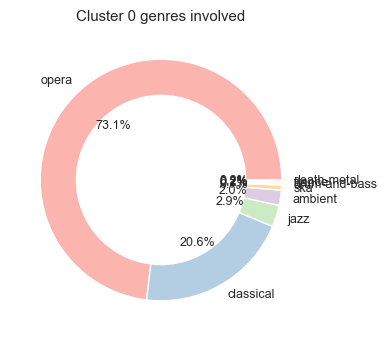

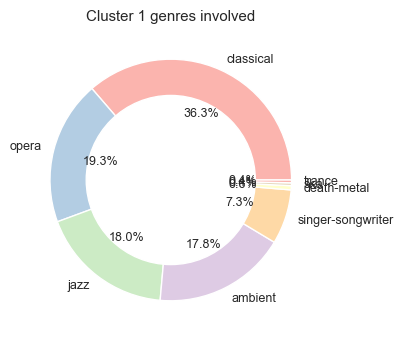

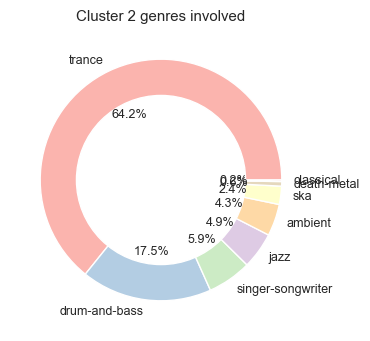

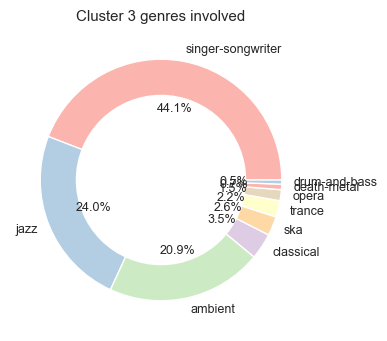

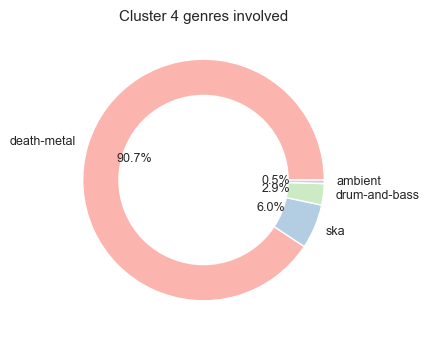

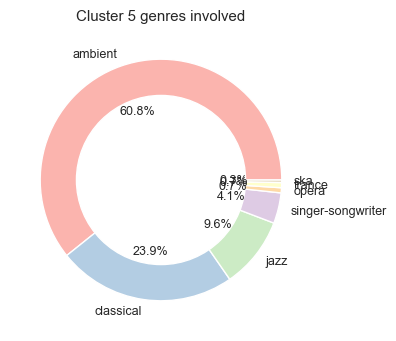

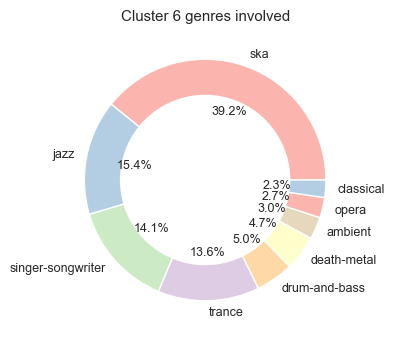

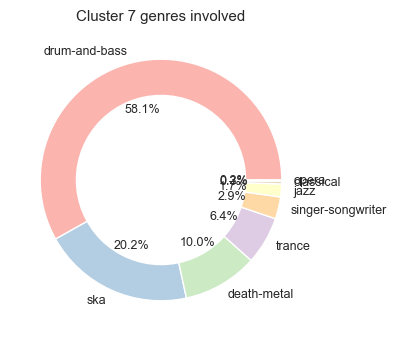

In [91]:
# Analizamos como estan conformados nuestros clusters en base a su genero
from palettable.colorbrewer.qualitative import Pastel1_7
import matplotlib as mpl
mpl.rcParams['font.size'] = 9.0

def plot_pie(data, cluster):
    circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(
        data.values.tolist(),
        labels=data.index.tolist(),
        colors=Pastel1_7.hex_colors,
        autopct="%.1f%%"
    )
    p = plt.gcf()
    p.gca().add_artist(circle)
    plt.title("Cluster {} genres involved".format(cluster))
    plt.show()


for cluster in sorted(tmp.Clusters.unique()):
    cluster_data = tmp[tmp['Clusters'] == cluster].Genres.value_counts()
    plot_pie(cluster_data, cluster)

In [ ]:
# Clusterizamos nuestros datos con k-means
k = 8
kmeans = KMeans(
        n_clusters=k,
        random_state=seed
    )

def plot_kmeans_matrix(dataset, description):
    kmeans.fit(dataset)
    Z = kmeans.predict(dataset)
    Z2 = [genres[x] for x in Z]
    plot_conf_matrix(genre_real.values, Z2,genres,description)


In [ ]:
plot_kmeans_matrix(df_numeric, "Raw Numeric Data K-means")

In [ ]:
plot_kmeans_matrix(df_numeric_normal, "Normal Numeric Data K-means")

In [ ]:
plot_kmeans_matrix(df_numeric_uniform, "Uniform Numeric Data K-means")

